#Importing libraries and dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
HEIGHT = 128
WIDTH = 128
CHANNELS = 3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import keras.backend as K
import warnings
from sklearn.utils import compute_class_weight
import pywt

In [ ]:
tf.random.set_seed(42)

In [ ]:
images = []
classes_labels = []
for i in os.listdir("/content/drive/MyDrive/Special_Issue_COVID_Journal/original_dataset/train"):
  class_path = f"/content/drive/MyDrive/Special_Issue_COVID_Journal/original_dataset/train/{i}"
  if(i == "Lung opacity"):
    continue
  for j in os.listdir(class_path):
    file_path = f"{class_path}/{j}"
    classes_labels.append(i)
    images.append(cv2.resize(cv2.imread(file_path, 1), (HEIGHT, WIDTH)))

In [ ]:
test_images = []
test_classes_labels = []
for i in os.listdir("/content/drive/MyDrive/Special_Issue_COVID_Journal/original_dataset/test"):
  class_path = f"/content/drive/MyDrive/Special_Issue_COVID_Journal/original_dataset/test/{i}"
  if(i == "Lung opacity"):
    continue
  for j in os.listdir(class_path):
    file_path = f"{class_path}/{j}"
    test_classes_labels.append(i)
    test_images.append(cv2.resize(cv2.imread(file_path, 1), (HEIGHT, WIDTH)))

In [ ]:
train_images, validation_images, train_labels, validation_labels = train_test_split(images, classes_labels, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

In [ ]:
class_weights

array([1.1889332 , 0.55529686, 2.79274005])

In [ ]:
weights = dict(zip([0, 1, 2], class_weights))

In [ ]:
weights

{0: 1.1889332003988036, 1: 0.5552968568102444, 2: 2.7927400468384076}

In [ ]:
train_images = np.asarray(train_images)
validation_images = np.asarray(validation_images)
train_labels = np.asarray(train_labels)
validation_labels = np.asarray(validation_labels)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
validation_labels = lb.transform(validation_labels)

In [ ]:
test_classes_labels = lb.transform(test_classes_labels)

In [ ]:
test_images = np.asarray(test_images)
test_classes_labels = np.asarray(test_classes_labels)

#Data Visualization

In [ ]:
def data(history):
  return pd.DataFrame(data=list(zip(history.history["accuracy"], history.history["val_accuracy"], history.history["loss"], history.history["val_loss"], history.history["recall"], history.history["val_recall"], history.history["precision"], history.history["val_precision"], history.history["auc"], history.history["val_auc"], history.history["specificity"], history.history["val_specificity"], history.history["sensitivity"], history.history["val_sensitivity"], history.history["mcc"], history.history["val_mcc"])) , columns=["Accuracy", "Validation Accuracy", "Loss", "Validation Loss", "Recall", "Validation Recall", "Precision", "Validation Precision", "AUC", "Validation AUC", "Specificity", "Validation Specificity" ,"Sensitivity", "Validation Sensitivity", "MCC", "Validation MCC"])

In [ ]:
def history_visualization(df):
  sns.set_style('darkgrid')
  nrow = 4
  ncol = 2
  df_columns = df.columns
  df_list = [df[col] for col in df]
  titles=["Accuracy Visualization", "Loss Visualization", "Recall Visualization", "Precision Visualization", "AUC Visualization", "Specificity Visualization", "Sensitivity Visualization", "MCC Visualization"]
  fig, axes = plt.subplots(nrow, ncol, figsize=(20, 16))
  count = 0
  i = 0
  for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c], x="Number of Epochs", legend="brief", label=df_columns[count], marker="o").set_title(titles[i])
        df_list[count+1].plot(ax=axes[r, c], x="Number of Epochs", legend="brief" ,label=df_columns[count+1], marker="o").set_title(titles[i])
        i+=1
        count+=2

In [ ]:
early_stoping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

#Custom Metrics using Tensorflow

In [ ]:
def true_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.linalg.diag_part(res), axis = 0)

def false_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def false_negative(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def true_negative(y_true, y_pred):
  y_true_res = tf.argmax(y_true)
  y_pred_res = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true_res, y_pred_res, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1), axis=0) - (false_negative(y_true, y_pred) + false_positive(y_true, y_pred) + true_positive(y_true, y_pred))

In [ ]:
def sensitivity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TP)
    den = float(TP + FN + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

def specificity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TN)
    den = float(TN + FP + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

In [ ]:
def mcc(y_true, y_pred):
  y_true = tf.argmax(y_true).numpy()
  y_pred = tf.argmax(y_pred).numpy()

  return tf.constant(matthews_corrcoef(y_true, y_pred))

In [ ]:
def f1_score(y_true, y_pred): 
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [ ]:
class ThresholdCallback(keras.callbacks.Callback):
  def __init__(self, threshold):
    self.threshold = threshold
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("val_loss") < self.threshold):
      self.model.stop_training = True

#Image Generator

In [ ]:
import collections, numpy

In [ ]:
from collections import Counter

In [ ]:
num_images = [3143, 5084, 6728, 1345]

In [ ]:
sum(num_images)

16300

In [ ]:
num_classes = len(num_images)-1

In [ ]:
beta_values = [(1 - (x / sum(num_images))) / num_classes for x in num_images]

In [ ]:
beta = dict(zip([0, 1, 2, 3], beta_values))

In [ ]:
image_generator = ImageDataGenerator(validation_split = 0.2, rescale=1./255)

In [ ]:
train_dataset = image_generator.flow(train_images, train_labels, shuffle=True, subset="training", seed=42)

In [ ]:
validation_dataset = image_generator.flow(validation_images, validation_labels, shuffle=True, subset="training", seed=42)

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_set = test_generator.flow(test_images, test_classes_labels, shuffle=False, seed=42)

In [ ]:
beta

{0: 0.26905930470347644,
 1: 0.22936605316973413,
 2: 0.19574642126789366,
 3: 0.3058282208588957}

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath="/content/model/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5", monitor="val_loss", save_weights_only=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience = 7, monitor = "val_loss", restore_best_weights = True, mode="min")

In [ ]:
threshold = ThresholdCallback(0.2)

In [ ]:
os.mkdir("/content/model")

#Base Resnet 18 Model

In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = tf.keras.initializers.GlorotUniform()

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, **kwargs):

        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform())
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        return out

In [ ]:
base_model = ResNet18()

In [ ]:
model = keras.models.Sequential([base_model, keras.layers.Flatten(), keras.layers.Dense(3, activation="softmax")])

In [ ]:
model.build(input_shape = (None,HEIGHT, WIDTH, CHANNELS))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net18 (ResNet18)        (None, 512)               11190912  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                                 
Total params: 11,192,451
Trainable params: 11,182,851
Non-trainable params: 9,600
_________________________________________________________________


In [ ]:
base_model_2 = keras.models.load_model("/content/drive/MyDrive/Special_Issue_COVID_Journal/base_model_epooch_4", custom_objects={"res_net18" : ResNet18, "specificity" : specificity, "sensitivity" : sensitivity, "mcc" : mcc, "f1_score" : f1_score})

In [ ]:
base_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net18 (ResNet18)        (None, 512)               11190912  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 14)                7182      
                                                                 
Total params: 11,198,094
Trainable params: 11,188,494
Non-trainable params: 9,600
_________________________________________________________________


In [ ]:
resnet_layer_2 = base_model_2.get_layer("res_net18")

In [ ]:
resnet_2_weights = resnet_layer_2.get_weights()

In [ ]:
resnet_layer_1 = model.get_layer("res_net18")

In [ ]:
resnet_layer_1.set_weights(resnet_2_weights)

#ResNet18 with custom weights III


In [ ]:
lb.classes_

array(['COVID', 'Normal', 'Viral Pneumonia'], dtype='<U15')

In [ ]:
weights = {
    0 : 0.3686,
    1 : 0.302,
    2 : 0.3391

}

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
history = model.fit(x=train_dataset, validation_data=validation_dataset, epochs=25, batch_size=32, callbacks=[early_stopping, model_checkpoint], class_weight=weights)

Epoch 1/25
179/179 [==============================] - 43s 173ms/step - loss: 0.0899 - accuracy: 0.8933 - precision: 0.8983 - recall: 0.8884 - auc: 0.9790 - specificity: 0.0559 - sensitivity: 0.0838 - mcc: 0.1732 - val_loss: 0.6307 - val_accuracy: 0.7612 - val_precision: 0.7680 - val_recall: 0.7514 - val_auc: 0.9236 - val_specificity: 0.0444 - val_sensitivity: 0.0667 - val_mcc: 0.1111
Epoch 2/25
179/179 [==============================] - 31s 170ms/step - loss: 0.0506 - accuracy: 0.9429 - precision: 0.9440 - recall: 0.9425 - auc: 0.9925 - specificity: 0.0894 - sensitivity: 0.0726 - mcc: 0.1934 - val_loss: 0.9337 - val_accuracy: 0.7437 - val_precision: 0.7456 - val_recall: 0.7409 - val_auc: 0.8992 - val_specificity: 0.1333 - val_sensitivity: 0.0444 - val_mcc: 0.2148
Epoch 3/25
179/179 [==============================] - 31s 171ms/step - loss: 0.0348 - accuracy: 0.9610 - precision: 0.9615 - recall: 0.9603 - auc: 0.9961 - specificity: 0.0838 - sensitivity: 0.0615 - mcc: 0.1743 - val_loss: 0.

In [ ]:
df = data(history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.893256,0.761173,0.089920,0.630663,0.888365,0.751397,0.898251,0.768023,0.979006,0.923649,0.055866,0.044444,0.083799,0.066667,0.173184,0.111111
1,0.942872,0.743715,0.050557,0.933735,0.942523,0.740922,0.944007,0.745608,0.992486,0.899180,0.089385,0.133333,0.072626,0.044444,0.193365,0.214815
2,0.961041,0.811453,0.034781,0.448449,0.960342,0.802374,0.961518,0.818376,0.996092,0.950895,0.083799,0.111111,0.061453,0.088889,0.174325,0.200000
3,0.963662,0.792598,0.030945,0.497045,0.962439,0.789804,0.964292,0.796479,0.996761,0.941048,0.089385,0.066667,0.072626,0.066667,0.166876,0.148148
4,0.980433,0.854050,0.019752,0.420823,0.980084,0.852654,0.981112,0.854444,0.998419,0.963204,0.111732,0.088889,0.050279,0.066667,0.183636,0.172035
5,0.979560,0.865223,0.017663,0.404449,0.979210,0.865223,0.979724,0.865223,0.999061,0.964249,0.100559,0.111111,0.061453,0.044444,0.165736,0.170370
6,0.984102,0.901536,0.015297,0.350356,0.984102,0.900140,0.984102,0.902029,0.999223,0.973333,0.134078,0.244444,0.083799,0.022222,0.220880,0.262131
7,0.989867,0.947626,0.009590,0.184136,0.989693,0.947626,0.990558,0.949615,0.999759,0.989493,0.122905,0.066667,0.117318,0.066667,0.217877,0.158427
8,0.982355,0.845670,0.016843,0.551435,0.982355,0.845670,0.982527,0.845670,0.999007,0.951693,0.111732,0.200000,0.039106,0.088889,0.168320,0.174906
9,0.991440,0.940642,0.007868,0.164979,0.991440,0.938547,0.991440,0.941176,0.999572,0.991774,0.201117,0.111111,0.083799,0.044444,0.230191,0.128797


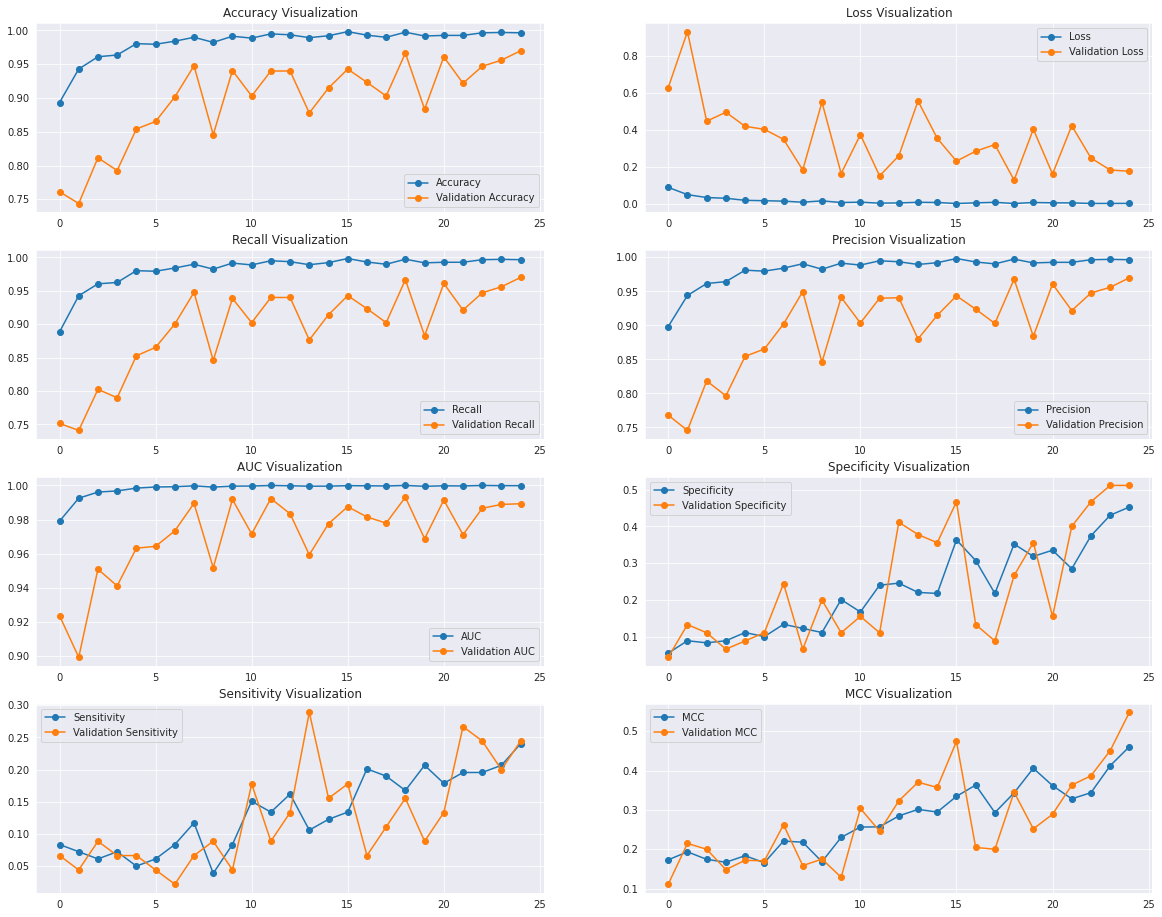

In [ ]:
history_visualization(df)

##Prediction

In [ ]:
model.load_weights("/content/model/my_best_model.epoch19-loss0.13.hdf5")

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(directory="/content/drive/MyDrive/Special_Issue_COVID_Journal/original_dataset/test", target_size=(HEIGHT, WIDTH), color_mode="rgb", class_mode="categorical", shuffle=False)

Found 3254 images belonging to 4 classes.


In [ ]:
test_dataset.class_indices

{'COVID': 0, 'Lung opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [ ]:
train_dataset.class_indices

{'COVID': 0, 'Lung opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [ ]:
predictions = model.predict(test_set)

In [ ]:
predictions_index = lb.inverse_transform(predictions)

In [ ]:
predictions_index = lb.inverse_transform(predictions)
print(classification_report(predictions_index, lb.inverse_transform(test_set.y)))

                 precision    recall  f1-score   support

          COVID       0.93      0.95      0.94       618
         Normal       0.98      0.97      0.98      1341
Viral Pneumonia       0.99      0.95      0.97       278

       accuracy                           0.97      2237
      macro avg       0.97      0.96      0.96      2237
   weighted avg       0.97      0.97      0.97      2237



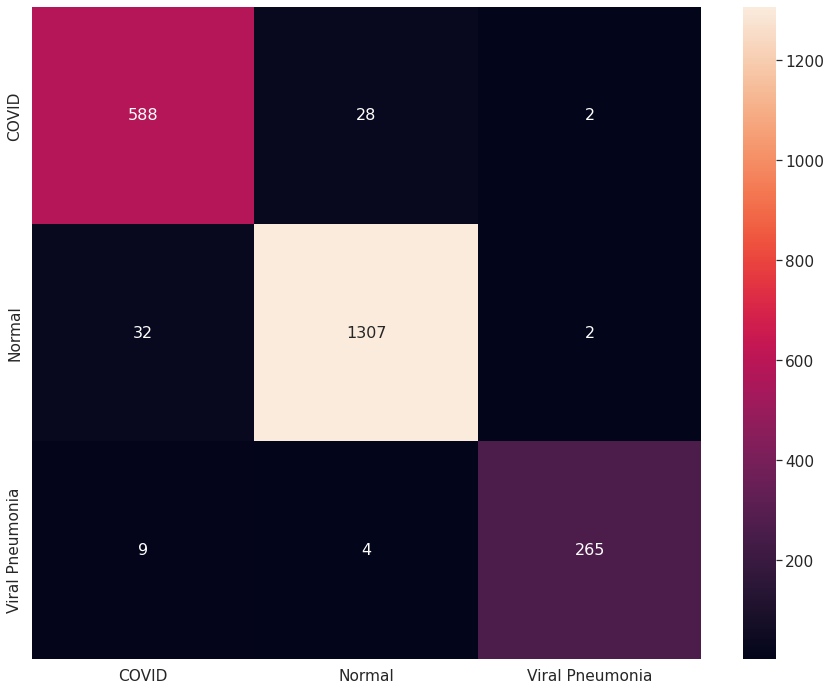

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(predictions_index, lb.inverse_transform(test_set.y))
df_cm = pd.DataFrame(cm, index = [i for i in lb.classes_],
                  columns = [i for i in lb.classes_])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve, roc_auc_score
bin = LabelBinarizer()
x_test = bin.fit_transform(lb.inverse_transform(test_set.y))
pred = bin.transform(predictions_index)
print(roc_auc_score(x_test, pred))

0.9721540878546208


In [ ]:
tf.keras.models.save_model(model, "/content/custom")

In [ ]:
!zip -r /content/4.zip /content/custom

  adding: content/custom/ (stored 0%)
  adding: content/custom/saved_model.pb (deflated 92%)
  adding: content/custom/variables/ (stored 0%)
  adding: content/custom/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/custom/variables/variables.index (deflated 79%)
  adding: content/custom/assets/ (stored 0%)
  adding: content/custom/keras_metadata.pb (deflated 94%)
